In [6]:
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

In [17]:
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

In [18]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

def idx_to_text(i):
    return cats[i]

def visualize_predictions(image, outputs, threshold=0.8):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled)


# Random colors used for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10,
                bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.show()
    # plt.savefig("image.png")

In [19]:
MODEL_NAME = "valentinafeve/yolos-fashionpedia"
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)

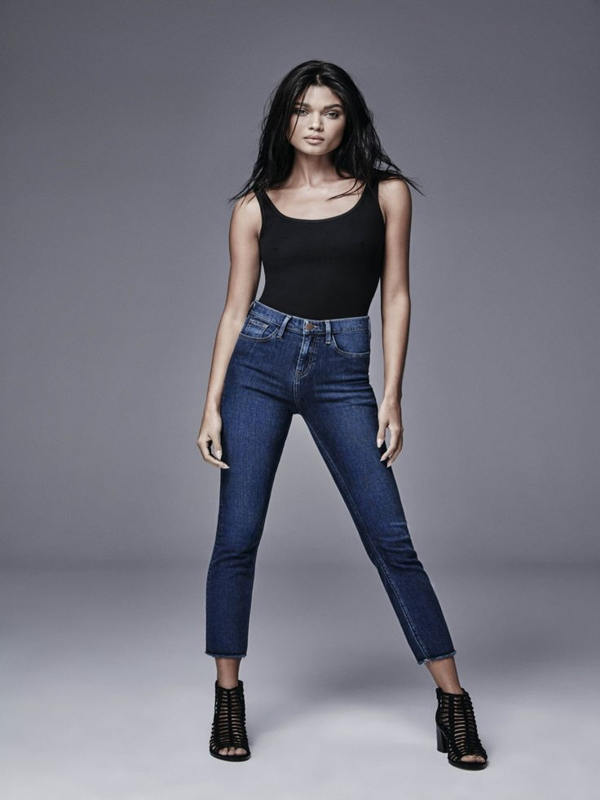

In [40]:
images_path = "test_images/2.jpg"

image = Image.open(open(images_path, "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
image

In [41]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

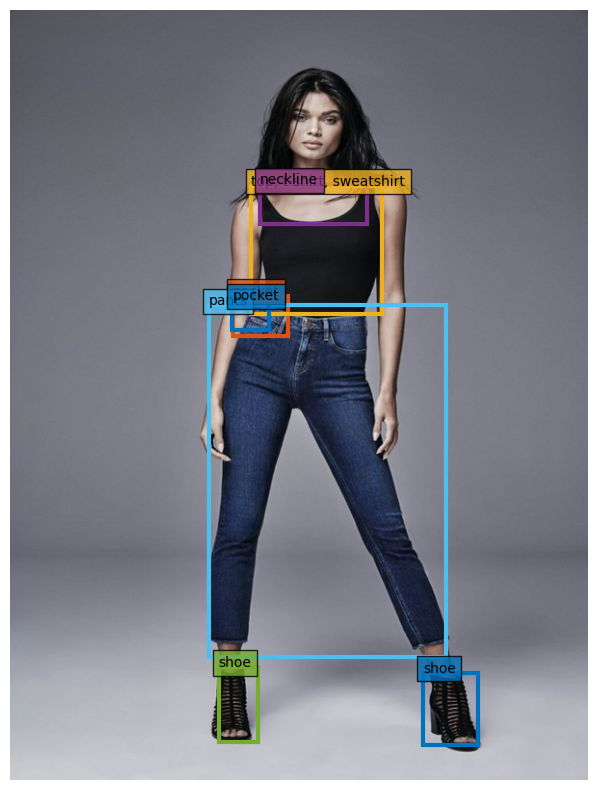

<Figure size 640x480 with 0 Axes>

In [42]:
visualize_predictions(image, outputs, threshold=0.8)

In [57]:
from PIL import Image, ImageDraw, ImageFont
import os
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter

def get_dominant_color(image, num_clusters=13):
    # Resize image to speed up processing
    small_image = image.resize((50, 50))
    # Convert image data to a sequence of pixels
    np_image = np.array(small_image)
    np_image = np_image.reshape((np_image.shape[0] * np_image.shape[1], 3))
    # Find clusters of colors
    clusters = KMeans(n_clusters=num_clusters).fit(np_image)
    # Count labels to find the most common cluster
    counts = Counter(clusters.labels_)
    # Find the most common cluster center
    center = clusters.cluster_centers_[counts.most_common(1)[0][0]]
    return tuple(center.astype(int))

def rgb_to_color_name(rgb):
    # Define your color mapping
    colors = {
        'red': (255, 0, 0),
        'brown': (165, 42, 42),
        'orange': (255, 165, 0),
        'yellow': (255, 255, 0),
        'pink': (255, 192, 203),
        'purple': (128, 0, 128),
        'violet': (238, 130, 238),
        'indigo': (75, 0, 130),
        'grey': (128, 128, 128),
        'green': (0, 128, 0),
        'blue': (0, 0, 255),
        'black': (0, 0, 0),
        'white': (255, 255, 255),
        'cyan': (0, 255, 255),
        'magenta': (255, 0, 255),
        'turquoise': (64, 224, 208),
        'gold': (255, 215, 0),
        'silver': (192, 192, 192),
        'bronze': (205, 127, 50),
        'beige': (245, 245, 220),
        'teal': (0, 128, 128),
        'maroon': (128, 0, 0),
        'olive': (128, 128, 0),
        'navy': (0, 0, 128),
        'coral': (255, 127, 80),
        'salmon': (250, 128, 114),
        'khaki': (240, 230, 140),
        'lavender': (230, 230, 250),
        'peach': (255, 218, 185),
        'mint': (189, 252, 201),
        'apricot': (251, 206, 177),
        'mustard': (255, 219, 88),
        'chartreuse': (127, 255, 0),
        'taupe': (72, 60, 50),
        'lilac': (200, 162, 200),
        # Add more colors as needed
    }
    color_name = "unknown"
    min_distance = float('inf')
    for name, color_rgb in colors.items():
        distance = sum((s - q) ** 2 for s, q in zip(rgb, color_rgb))  # Euclidean distance
        if distance <= min_distance:
            min_distance = distance
            color_name = name
    return color_name

def save_segmented_parts(image, outputs, threshold=0.8, output_dir='segmented_parts'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    to_be_ignored = ['sleeve', 'collar', 'pocket', 'neckline', 'buckle', 'zipper', 'applique',
                     'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle',
                     'sequin', 'tassel']

    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    for i, (p, box) in enumerate(zip(probas[keep], bboxes_scaled)):
        category = idx_to_text(p.argmax())
        if category in to_be_ignored:
            continue
        xmin, ymin, xmax, ymax = box.int().tolist()
        cropped_image = image.crop((xmin, ymin, xmax, ymax))

        dominant_color = get_dominant_color(cropped_image)
        color_name = rgb_to_color_name(dominant_color)  # Convert RGB to color name

        cropped_image.save(f"{output_dir}/{category}_{color_name}_{i}.jpg")
# Example usage:

# images_path = "test_images/black_shirt.jpg"
image_name = images_path.split("/")[-1].split(".")[0]
image = Image.open(open(images_path, "rb"))
image = fix_channels(ToTensor()(image))
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

# Call the modified function to save segmented parts
save_segmented_parts(image, outputs, threshold=0.8, output_dir=f"segmented_parts_{image_name}")


In [59]:
directory_path = 'userA_clothes'
for filename in os.listdir(directory_path):
    if filename.endswith(".jpg"):
        images_path = os.path.join(directory_path, filename)
        image_name = images_path.split("/")[-1].split(".")[0]
        image = Image.open(open(images_path, "rb"))
        image = fix_channels(ToTensor()(image))
        inputs = feature_extractor(images=image, return_tensors="pt")
        outputs = model(**inputs)

        save_segmented_parts(image, outputs, threshold=0.5, output_dir=f"segmented_parts_{directory_path}")

# Text Description

In [4]:
# import requests
# from PIL import Image
# from transformers import BlipProcessor, BlipForConditionalGeneration

# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# # img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
# # raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
# images_path = 'userA_clothes/images_1.jpg'
# raw_image = Image.open(open(images_path, "rb")).convert('RGB')

# # conditional image captioning
# text = "the clothes in the image "
# inputs = processor(raw_image, text, return_tensors="pt")

# out = model.generate(**inputs)
# print(processor.decode(out[0], skip_special_tokens=True))

the clothes in the image are black and white


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

c:\Users\aniru\OneDrive\Desktop\sbuhack\sbu\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aniru\.cache\huggingface\hub\models--google--owlvit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


[{'score': 0.10686874389648438,
  'label': 'clothing_article',
  'box': {'xmin': 32, 'ymin': 15, 'xmax': 179, 'ymax': 204}}]